# iLQR Racing Example

In [1]:
cd ..

/home/vjose/code/robotics-sandbox-py


In [2]:
import json

import tqdm
import numpy as np
import jax.numpy as jnp
import scipy as sp
from scipy import interpolate as spi
from scipy.stats import truncnorm
from matplotlib import pyplot as plt

from policies.ilqr import iLQR, iLQRConfig
from models.bicycle_model import (
    BicycleModelWithInputIntegrators,
    CurvilinearBicycleModelWithInputIntegrators,
)
import utils.track_utils as utils

In [3]:
def calc_curvature(x_spline, y_spline, s_values):
    dx = x_spline(s_values, 1)
    dy = y_spline(s_values, 1)
    ddx = x_spline(s_values, 2)
    ddy = y_spline(s_values, 2)
    num = dx * ddy - dy * ddx
    den = np.power((dx * dx + dy * dy + 1e-9), 3/2)
    return num / den

## Load track and fit track splines

Load track and create a cubic spline to query curvature values.

/home/vjose/code/robotics-sandbox-py/utils/track_utils.py:68: RuntimeWarning: divide by zero encountered in true_divide
  inv_slopes = -1.0 / slopes


Text(0.5, 1.0, 'Curvature')

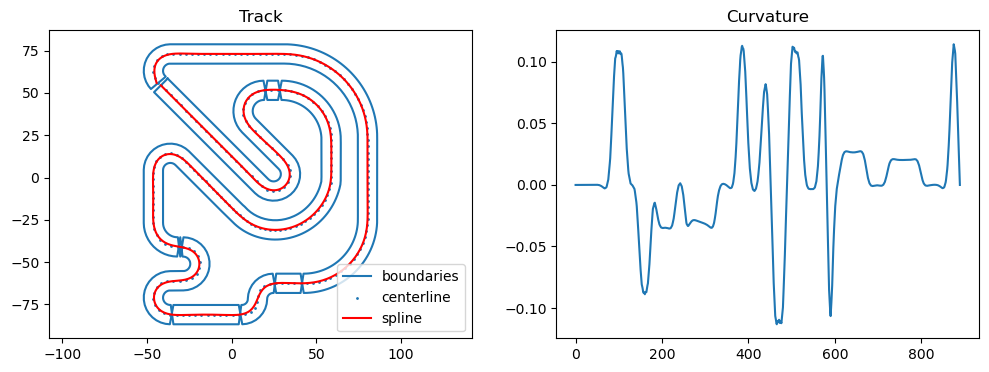

In [4]:
scale_factor = 50.0
with open('tracks/track.json', 'r') as f:
    data = json.load(f)
centerline_x, centerline_y = np.array(data['X']), np.array(data['Y'])
centerline = scale_factor* np.hstack((centerline_x[:, None], centerline_y[:, None]))

polygon = utils.centerline_to_polygon(centerline, width_scaling_factor=3.0)
# Subsample centerline, we do not need it that dense
centerline = centerline[::2]

diff_centerline = np.diff(centerline, axis=0)
diff_centerline = np.vstack((np.zeros((1, 2)), diff_centerline))

delta_s = np.linalg.norm(diff_centerline, axis=1)
abscissa_values = np.cumsum(delta_s)

regularization_val = 100.0
x_spline = spi.make_smoothing_spline(abscissa_values, centerline[:, 0], lam=regularization_val)
y_spline = spi.make_smoothing_spline(abscissa_values, centerline[:, 1], lam=regularization_val)

# Now plot the track with the fitted spline values
s = np.linspace(abscissa_values[0], abscissa_values[-1], 1000)
x_fitted = x_spline(s)
y_fitted = y_spline(s)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(polygon[:, 0], polygon[:, 1], label="boundaries")
ax[0].scatter(centerline[:, 0], centerline[:, 1], s=1.0, label="centerline")
ax[0].plot(x_fitted, y_fitted, color="red", label="spline")
ax[0].legend()
ax[0].axis("equal")
ax[0].set_title("Track")

k = calc_curvature(x_spline, y_spline, s)
ax[1].plot(s, k)
ax[1].set_title("Curvature")

### Create racing iLQR 

In [5]:
class RacingCostFunction(object):
    def __init__(self):
        #                                  s      d      mu     v       a     steer
        self.goal  = jnp.array(        [100.0,   0.0,   0.0,  10.0,    0.0,   0.0])
        base_cost  = jnp.diag(np.array([  0.0,   0.1,   0.1,   1.0,    0.0,   0.0]))
        final_cost = jnp.diag(np.array([  0.0, 100.0, 100.0,   1.0,    0.0,   0.0]))
        self.lb    = jnp.array(        [  0.0,  -3.0,  -0.5,   0.0,   -1.0,  -0.5])
        self.ub    = jnp.array(        [  0.0,   3.0,   0.5,  10.0,    1.0,   0.5])
        self.q1    = jnp.array(        [  0.0,   0.3,   0.3,   0.3,    0.3,   0.3])
        self.q2    = jnp.array(        [  0.0,  50.0,  50.0,  50.0,   50.0,  50.0])
        
        self.q1_nl = jnp.array([0.3, 0.3])
        self.q2_nl = jnp.array([5.0, 5.0])
        
        self.Q = 1.0 * base_cost
        self.Q_N = 1.0 * final_cost
        self.R = 0.1 * np.eye(2)

    def get_stage_cost(self, x, u, params):
        s, d, mu, v, a, steering = x
        k = params[0]
        s_dot = (v * jnp.cos(mu)) / (1 - d * k)
        
        barrier_function = lambda z, q1, q2: jnp.sum(jnp.clip(q1 * jnp.exp(q2 * (z)), 0.0, 1000.0))
        
        # lat accel (ay) upper and lower bound
        ay_lb, ay_ub = -1.0, 1.0
        ay = x[3] * x[3] * k
        g_nl = jnp.array([ay_lb - ay, ay - ay_ub])
        
        cost = -0.1 * s_dot                                            # progress contribution
        cost += (x - self.goal).T @ self.Q @ (x - self.goal)           # reference tracking
        cost += u.T @ self.R @ u                                       # input cost
        cost += barrier_function(self.lb - x, self.q1, self.q2)        # box constraint lb
        cost += barrier_function(x - self.ub, self.q1, self.q2)        # box constraint ub
        cost += barrier_function(g_nl, self.q1_nl, self.q2_nl)         # nl constraint lb
        
        return cost

    def get_terminal_cost(self, x, params):
        s, d, mu, v, a, steering = x
        k = params[0]
        s_dot = (v * jnp.cos(mu)) / (1 - d * k)
        
        barrier_function = lambda z, q1, q2: jnp.sum(jnp.clip(q1 * jnp.exp(q2 * (z)), 0.0, 1000.0))
        
        # lat accel (ay) upper and lower bound
        ay_lb, ay_ub = -1.0, 1.0
        ay = x[3] * x[3] * k
        g_nl = jnp.array([ay_lb - ay, ay - ay_ub])
        
        cost = -0.1 * s_dot                                            # progress contribution
        cost += (x - self.goal).T @ self.Q @ (x - self.goal)           # reference tracking
        cost += barrier_function(self.lb - x, self.q1, self.q2)        # box constraint lb
        cost += barrier_function(x - self.ub, self.q1, self.q2)        # box constraint ub
        cost += barrier_function(g_nl, self.q1_nl, self.q2_nl)         # nl constraint lb
        return cost

dynamics = CurvilinearBicycleModelWithInputIntegrators()
xy_dynamics = BicycleModelWithInputIntegrators()
cost_function = RacingCostFunction()

config = iLQRConfig(horizon=30, iters=10)
policy = iLQR(config, dynamics, cost_function)

policy.params_function = lambda x, u: calc_curvature(x_spline, y_spline, x[:, 0, None])

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [7]:
# Define a callback function to extract the intermediate solutions of the optimization problem
x_solutions = []
u_solutions = []
curvatures = []
def callback_fn(iter, x, u):
    x_solutions.append(x)
    u_solutions.append(u)
    curvatures.append(policy.params_function(x, u))

initial_state = np.array([50.0, -2.0, -0.1, 3.0, 0.0, 0.0])
x_final_solution, _ = policy.solve(initial_state, callback=callback_fn)

### Visualize the iterations of the optimization problem


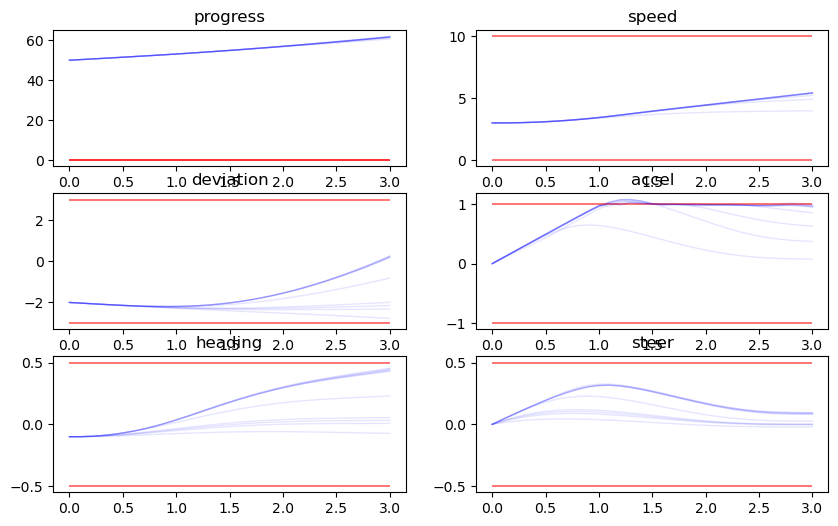

In [8]:
fig, ax = plt.subplots(3, 2, figsize=(10, 6))
lb = cost_function.lb
ub = cost_function.ub
    
def plot_trajectory(ax, trajectory, alpha, color, time_0=0.0, lw=1.0):
    ts = 0.1
    times = time_0 + ts * np.arange(len(trajectory)) 
    
    def plot_traj(ax, index, title):
        ax.plot(times, trajectory[:, index], alpha=alpha, color=color, lw=lw)
        ax.set_title(title)
        ax.hlines([ub[index], lb[index]], times[0], times[-1], colors="red", linestyle='-', lw=0.1)
        
    plot_traj(ax[0,0], 0, "progress")
    plot_traj(ax[1,0], 1, "deviation")
    plot_traj(ax[2,0], 2, "heading")
    plot_traj(ax[0,1], 3, "speed")
    plot_traj(ax[1,1], 4, "accel")
    plot_traj(ax[2,1], 5, "steer")
    
for x_solution in x_solutions:
    plot_trajectory(ax, x_solution, alpha=0.1, color="blue")
plt.show()

### Closed loop simulation of the system on the track

In [9]:
state = np.copy(initial_state)

trajectory = [state]
plans = []

warmstart_u = None
warmstart_x = None
for i in tqdm.tqdm(range(500)):
    
    x, u = policy.solve(state, warmstart=warmstart_u, warmstart_x=warmstart_x)
    plans.append(x)
    
    warmstart_u = np.vstack((u[1:], u[-1]))
    warmstart_x = np.vstack((x[1:], x[-1]))
    
    # Propagate the state using the dynamics function
    params = policy.params_function(x, u)
    state = np.array(dynamics(state, u[0], params[0]))
    
    # Inject some noise to the current state to simulate real world scenarios, first only to
    # the speed.
    deviation_noise= 0.000 * truncnorm.rvs(-2.0, 2.0, scale=1.0,size=1)
    heading_noise = 0.000 * truncnorm.rvs(-2.0, 2.0, scale=1.0,size=1)
    speed_noise = 0.00 * truncnorm.rvs(-2.0, 2.0, scale=1.0,size=1)
    state[1] = state[1] + deviation_noise
    state[2] = state[2] + heading_noise
    state[3] = state[3] + speed_noise
    
    trajectory.append(state)

trajectory = np.vstack(trajectory)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 75.42it/s]


### Visualize the resulting simulation

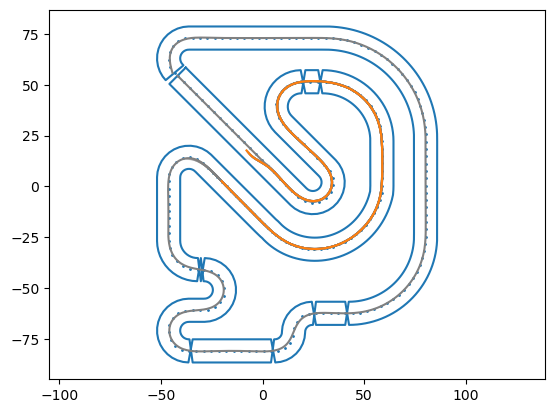

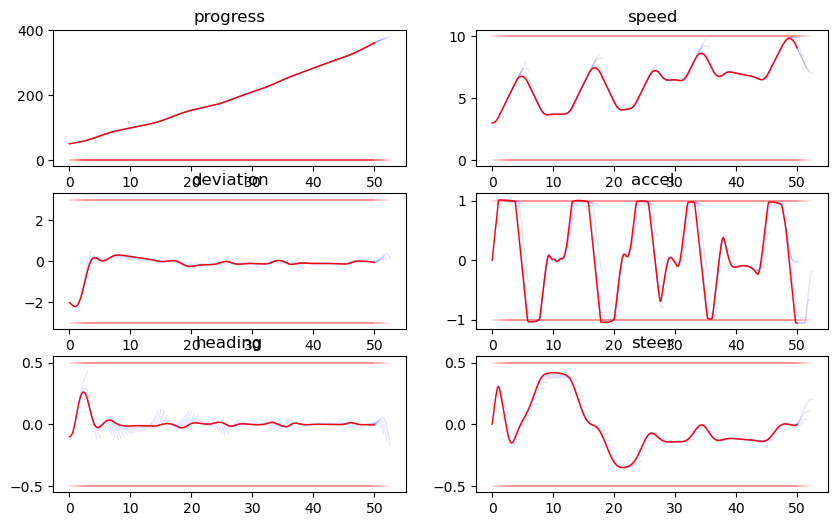

In [10]:
def convert_to_xy(x_spline, y_spline, s_values, d_values, mu_values):
    x = x_spline(s_values)
    y = y_spline(s_values)
    dx = x_spline(s_values, 1) + 1e-8
    dy = y_spline(s_values, 1)

    # compute the normal at each point
    normal = np.hstack((-dy[:, None], dx[:, None]))
    unit_normal = normal / np.linalg.norm(normal, axis=1)[:, None]

    new_x = x + d_values * unit_normal[:, 0]
    new_y = y + d_values * unit_normal[:, 1]
    
    # Compute the new heading values
    theta = np.arctan2(dy, dx) + mu_values
    
    return new_x[:, None], new_y[:, None], theta[:, None]

##################################################################
###### Plot the track and the planned trajectories.
##################################################################

x_values, y_values, theta_values = convert_to_xy(
    x_spline, y_spline, trajectory[:, 0], trajectory[:, 1], trajectory[:, 2])

for plan in plans:
    x_plan, y_plan, theta_plan = convert_to_xy(
        x_spline, y_spline, plan[:, 0], plan[:, 1], plan[:, 2])
    plt.plot(x_plan, y_plan, color="gray", alpha=0.2)


plt.plot(polygon[:, 0], polygon[:, 1], label="boundaries")
plt.plot(x_fitted, y_fitted, color="gray", linestyle='-', label="spline")
plt.scatter(centerline[:, 0], centerline[:, 1], s=1.0, label="centerline")
plt.plot(x_values, y_values)
plt.axis("equal")
plt.show()

##################################################################
###### Plot the states
##################################################################

fig, ax = plt.subplots(3, 2, figsize=(10, 6))
time_s = 0.0
n_subsample = 5
for plan in plans[::n_subsample]:
    plot_trajectory(ax, plan, alpha=0.1, time_0=time_s, color="blue")
    time_s += n_subsample * 0.1

plot_trajectory(ax, trajectory, alpha=1.0, color='red')

plt.show()